In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2 as pg

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
db_params = {
    "dbname": "sikkaretail_db",
    "user": "psgpyc",
    "password": "",
    "host": "localhost",
    "port": 5432
}

In [4]:
try:
    conn = pg.connect(**db_params)
    curr = conn.cursor()
    print(f"Successfully Connected to the {db_params['dbname']}")
except psycopg2.Error as e:
    print("Error connecting to the database:", e)

Successfully Connected to the sikkaretail_db


### RFM Segmentation

In [32]:
curr.execute(
'''
WITH customers_orders AS (
	SELECT
		i.customer_id,
		MAX(i.invoice_date) AS last_purchase_date,
		COUNT(DISTINCT i.invoice_no) AS frequency, 
		SUM(ii.quantity * ii.unit_price) AS monetary
	FROM 
		invoices i
	JOIN
		invoice_items ii
	ON 
		i.invoice_no = ii.invoice_no
	WHERE
		i.is_cancelled = FALSE AND i.customer_id != '00000'
	GROUP BY
		i.customer_id),
rfm_calculation AS (
	SELECT 
		customer_id, 
		DATE_PART('day', DATE '2012-01-01' - last_purchase_date) AS days_since_last_purchase, 
		frequency,
		monetary,
		--- We want customers with lower dates to score higgher, therefore inverting the socre. // now, higher score is better // consistent with freq and mon score.
		(6 - NTILE(5) OVER (ORDER BY DATE_PART('day', DATE '2012-01-01' - last_purchase_date))) AS recency_score,

		--- Higer the frequency and monetary score, suggest frequent orders and high monetary value
		NTILE(5) OVER (ORDER BY frequency) AS frequency_score, 
		NTILE(5) OVER (ORDER BY monetary) AS monetary_score
	FROM
		customers_orders
), rfm_score AS (
SELECT

	customer_id, 
	recency_score, 
	frequency_score, 
	monetary_score,
	(recency_score+frequency_score+monetary_score) AS overall_rfm_score
FROM
	rfm_calculation),
segments AS (	
SELECT
	customer_id, 
	overall_rfm_score, 
	CASE
		WHEN recency_score = 5 AND frequency_score = 5 AND monetary_score = 5 THEN 'Champions'
		WHEN overall_rfm_score >= 12 THEN 'Loyal'
		WHEN overall_rfm_score >= 9 THEN 'Less Frequent'
		WHEN overall_rfm_score >= 6 THEN 'At Risk'
		ELSE 'Dormant'
	END AS customer_segment
FROM rfm_score)
SELECT
	customer_segment,
	COUNT(*) AS customer_count,
	ROUND(COUNT(*) * 100.0 / (SELECT COUNT(*) FROM segments), 2) AS segment_percentage
FROM
	segments
GROUP BY 
	customer_segment
''')

In [33]:
rfm = pd.DataFrame(curr.fetchall(), columns=['customer_segment','customer_count', '%_of_total'])

In [34]:
rfm

,customer_segment,customer_count,%_of_total
0,Less Frequent,1065,24.55
1,Loyal,903,20.82
2,Champions,344,7.93
3,Dormant,898,20.70
4,At Risk,1128,26.00


Text(0.5, 1.0, 'Customer Segmentation using RFM Segmentation')

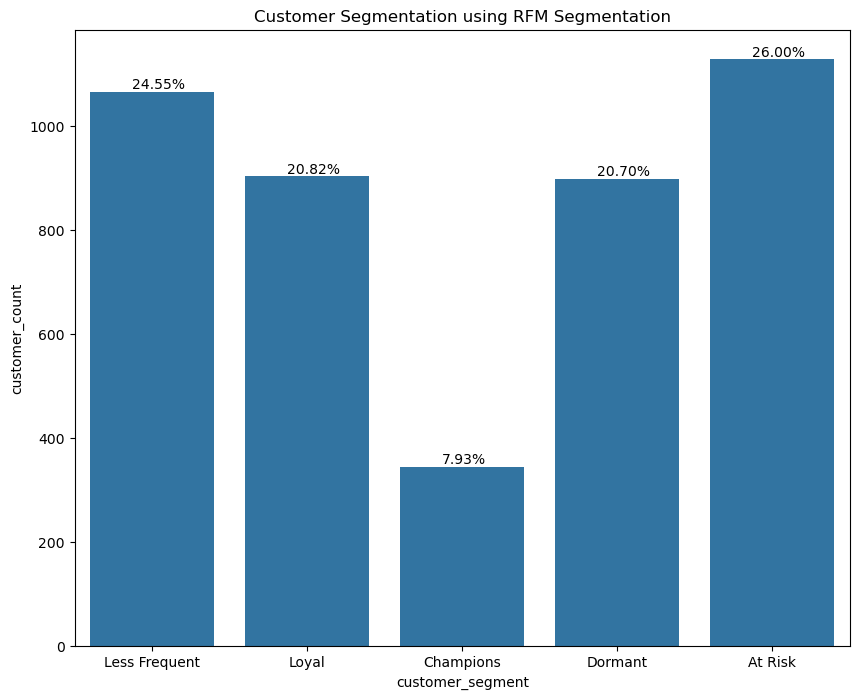

In [52]:
fig, ax = plt.subplots(1,1, figsize=(10,8))
bars = sns.barplot(rfm, x='customer_segment', y='customer_count')
for each, total_per in zip(ax.patches, rfm['%_of_total']):
    width_ = each.get_width()
    ax.text(each.get_x() + (width_/3), each.get_height() + 6, f"{total_per}%")

ax.set_title('Customer Segmentation using RFM Segmentation')

## Cohert Analysis

In [57]:
curr.execute(
'''
WITH first_purchase AS (
  SELECT 
    customer_id, 
    MIN(invoice_date) AS first_purchase_date
  FROM invoices
  WHERE is_cancelled = FALSE
  GROUP BY customer_id
),
customer_orders AS (
  SELECT 
    i.customer_id,
    i.invoice_date,
    fp.first_purchase_date,
    DATE_TRUNC('month', fp.first_purchase_date) AS cohort_month, 
    -- Months elapsed since the first purchase // muyltiplying by year by 12 to convert in months.
	
    ( (DATE_PART('year', i.invoice_date) * 12 + DATE_PART('month', i.invoice_date)) - 
      (DATE_PART('year', fp.first_purchase_date) * 12 + DATE_PART('month', fp.first_purchase_date)) ) AS months_since_first_purchase
  FROM invoices i
  JOIN first_purchase fp ON i.customer_id = fp.customer_id
  WHERE i.is_cancelled = FALSE
)
SELECT 
  TO_CHAR(cohort_month, 'YYYY-MM') AS cohort,
  months_since_first_purchase,
  COUNT(DISTINCT customer_id) AS active_customers
FROM customer_orders
GROUP BY cohort_month, months_since_first_purchase
ORDER BY cohort_month, months_since_first_purchase;

'''    
)

In [58]:
cohert_df = pd.DataFrame(curr.fetchall(), columns=['cohert_by_month', 'months_since_last_purchase', 'total_customers'])

In [59]:
cohert_df

,cohert_by_month,months_since_last_purchase,total_customers
0,2010-12,0.0,886
1,2010-12,1.0,325
2,2010-12,2.0,287
3,2010-12,3.0,341
4,2010-12,4.0,322
...,...,...,...
86,2011-10,1.0,86
87,2011-10,2.0,41
88,2011-11,0.0,323
89,2011-11,1.0,36
